In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
from matplotlib.dates import DateFormatter

import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from scipy.signal import savgol_filter

# try:
#     %matplotlib inline
#     ! curl -o states-daily.csv 'https://covidtracking.com/api/v1/states/daily.csv'
# except:
#     print('Not in python notebook, images saved to file')
sns.set()



In [2]:
#Read in covid cases csv
url = 'https://covidtracking.com/api/v1/states/daily.csv'
corona = pd.read_csv(url, index_col=[1,0], parse_dates=[0])
corona.head()

,,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
state,date,,,,,,,,,,,,,,,,,,,,,
AK,2020-07-07,1184.0,130236.0,NaN,25.0,NaN,NaN,NaN,1.0,NaN,560.0,...,131420,1,0,7c7ab728f94cde83c2cd769a80f5de03648a7feb,0,0,0,0,0,NaN
AL,2020-07-07,45785.0,415579.0,NaN,1073.0,2961.0,NaN,858.0,NaN,479.0,22082.0,...,461364,26,47,8d8164f1d3922f1d9d55fff0e476fd676e62b009,0,0,0,0,0,NaN
AR,2020-07-07,24512.0,326143.0,NaN,369.0,1604.0,NaN,NaN,81.0,247.0,17834.0,...,350655,0,29,6cf299ce4e2a1d516a567a7cccc4ede3f04cb94e,0,0,0,0,0,NaN
AS,2020-07-07,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,696,0,0,2973dc8e4ea04137bef2fe10b8f00d33995bd48d,0,0,0,0,0,NaN
AZ,2020-07-07,105094.0,523703.0,NaN,3356.0,5272.0,869.0,NaN,544.0,NaN,12260.0,...,628797,117,84,7711d5a0f515f4ef6851368c3277989767f4800f,0,0,0,0,0,NaN


In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [5]:
# Read in state populations from census
state_populations = pd.read_csv('data/nst-est2019-01.csv', index_col=0, thousands=',')
state_populations.index = state_populations.index.map(us_state_abbrev)
state_populations.head()

,population
state,
AL,4903185
AK,731545
AZ,7278717
AR,3017804
CA,39512223


In [7]:
state_populations.to_dict()

{'population': {'AL': 4903185,
  'AK': 731545,
  'AZ': 7278717,
  'AR': 3017804,
  'CA': 39512223,
  'CO': 5758736,
  'CT': 3565287,
  'DE': 973764,
  'DC': 705749,
  'FL': 21477737,
  'GA': 10617423,
  'HI': 1415872,
  'ID': 1787065,
  'IL': 12671821,
  'IN': 6732219,
  'IA': 3155070,
  'KS': 2913314,
  'KY': 4467673,
  'LA': 4648794,
  'ME': 1344212,
  'MD': 6045680,
  'MA': 6892503,
  'MI': 9986857,
  'MN': 5639632,
  'MS': 2976149,
  'MO': 6137428,
  'MT': 1068778,
  'NE': 1934408,
  'NV': 3080156,
  'NH': 1359711,
  'NJ': 8882190,
  'NM': 2096829,
  'NY': 19453561,
  'NC': 10488084,
  'ND': 762062,
  'OH': 11689100,
  'OK': 3956971,
  'OR': 4217737,
  'PA': 12801989,
  'RI': 1059361,
  'SC': 5148714,
  'SD': 884659,
  'TN': 6829174,
  'TX': 28995881,
  'UT': 3205958,
  'VT': 623989,
  'VA': 8535519,
  'WA': 7614893,
  'WV': 1792147,
  'WI': 5822434,
  'WY': 578759,
  'PR': 3193694,
  'GU': 165718,
  'MP': 55194,
  'VI': 104914,
  'AS': 55641}}

In [6]:
# join state populations to covid data
corona = corona.join(state_populations, on='state')

In [99]:
corona.head()

,,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade,population
state,date,,,,,,,,,,,,,,,,,,,,,
AK,2020-06-25,816.0,98636.0,NaN,14.0,NaN,NaN,NaN,2.0,NaN,513.0,...,0,0,74506565ff9f0d6621e232e1e62239d658786e81,0,0,0,0,0,NaN,731545
AL,2020-06-25,33206.0,336252.0,NaN,693.0,2612.0,NaN,761.0,NaN,447.0,18866.0,...,5,45,17d9d87e1df190897ce93d3fcbb382e6dac460e3,0,0,0,0,0,NaN,4903185
AR,2020-06-25,18062.0,259318.0,NaN,284.0,1245.0,NaN,NaN,61.0,194.0,12127.0,...,0,31,651dd04526a06699eef6c83fc27f1850be5e46cb,0,0,0,0,0,NaN,3017804
AS,2020-06-25,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,191bf0110e14794659c0c2f75b655e51fc2b9fb7,0,0,0,0,0,NaN,55641
AZ,2020-06-25,63030.0,401166.0,NaN,2453.0,4406.0,611.0,NaN,415.0,NaN,8139.0,...,27,93,1ac05d6977f2752d59425412bbb0a63897260ea0,0,0,0,0,0,NaN,7278717


In [100]:
# sort on state
corona.sort_index(inplace=True)
# add percent of cases that are negative
corona['percentNegative'] = 100.0* corona['negativeIncrease'] / corona['totalTestResultsIncrease']

In [101]:
columns_to_plot = ['positiveIncrease', 'totalTestResultsIncrease', 'percentNegative']
titles = ['# Positive', '# Tests', '% Negative']


In [102]:
# is this increasing over the time span?
def isIncreasing(x):
    if x[0] < x[-1]:
        return True
    else:
        return False

In [103]:
# add columns for rolling average, and if it is increasing
for col in columns_to_plot:
    new_col_name = col+'Rolling'
    corona[new_col_name] = corona.groupby(level=0)[col].rolling(window=7).mean().values
    
    comparison_name = col+'IsIncreasing'
    corona[comparison_name] = corona.groupby(level=0)[new_col_name].rolling(window=7).apply(isIncreasing, raw=True).values
        


In [104]:
corona['positiveIncreaseRollingPer100k'] = 1e5*corona['positiveIncreaseRolling']/corona['population']

In [105]:
# create plots for each metric
def plot_bar_increasing (ts, title, isIncreasing, ax, increaseGreen=True, population=None):
    if increaseGreen:
        mapping = {True: 'g', False: 'r'}
    else:
        mapping = {False: 'g', True: 'r'}
        
    if population is not None:
        ts = 1e5*ts / population
    
    ts.plot(kind='bar',
           color = isIncreasing.map(mapping),
           ax=ax)
    ax.set_ylabel(title)

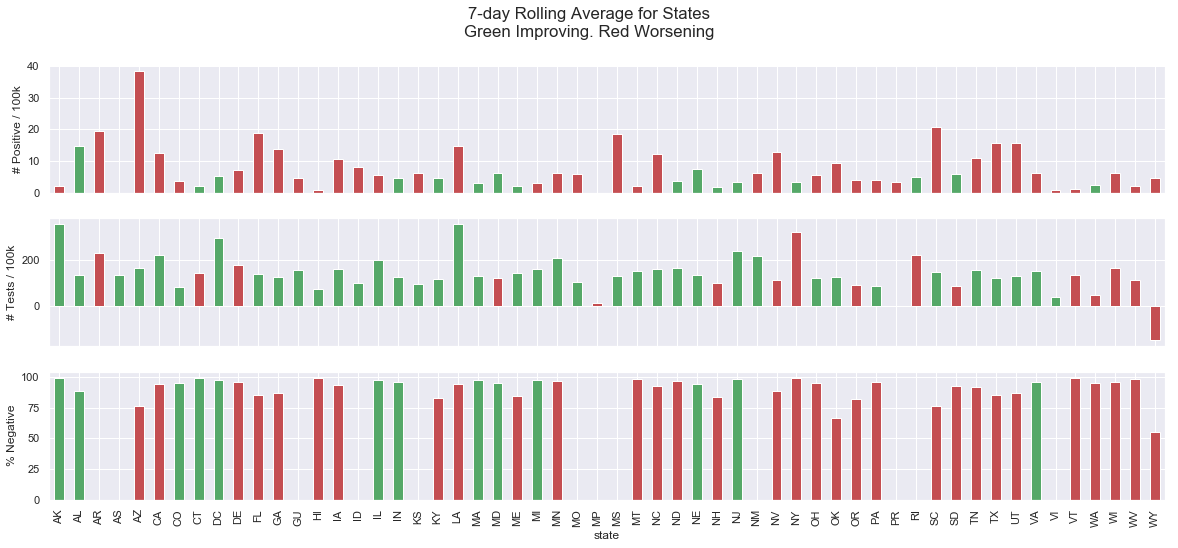

In [106]:
#plot 3 metrics
plt.rcParams.update({'font.size': 14})


# get most recent value for each state
corona_to_plot = corona.groupby(level='state').tail(1).reset_index(level=1, drop=True)

#create plot
fig, axs = plt.subplots(len(columns_to_plot), 1, sharex=True, figsize=(20,8))

# fill na with zeros
corona_to_plot.fillna(0.0, axis=1, inplace=True)

columns_to_plot = ['positiveIncrease', 'totalTestResultsIncrease', 'percentNegative']
titles = ['# Positive', '# Tests', '% Negative']

plt.suptitle('7-day Rolling Average for States\nGreen Improving. Red Worsening')

# plot positive cases
plot_bar_increasing(corona_to_plot['positiveIncrease'+'Rolling'], 
                    '# Positive / 100k', 
                    corona_to_plot['positiveIncrease'+'IsIncreasing'],
                    ax=axs[0],
                    increaseGreen=False,
                    population=corona_to_plot['population'])


#plot tests run
plot_bar_increasing(corona_to_plot['totalTestResultsIncrease'+'Rolling'], 
                    '# Tests / 100k', 
                    corona_to_plot['totalTestResultsIncrease'+'IsIncreasing'],
                    ax=axs[1],
                    increaseGreen=True,
                    population=corona_to_plot['population'])

#plot pct negative tests
plot_bar_increasing(corona_to_plot['percentNegative'+'Rolling'], 
                    '% Negative', 
                    corona_to_plot['percentNegative'+'IsIncreasing'],
                    ax=axs[2],
                    increaseGreen=True)


plt.savefig('images/state_by_state.pdf')
plt.savefig('images/state_by_state.svg')

In [107]:
# is each metric improving or declining 

pos_mapping = {True: 1, False: -1}
neg_mapping = {False: 1, True: -1}

def isIncreasingZeroCheck(pct_neg, pct_neg_incr):
    if pct_neg < 1:
        return 0
    if pct_neg_incr > 0:
        return 1
    else:
        return -1

rate_mappings = []
rate_mappings.append(corona_to_plot['positiveIncrease'+'IsIncreasing'].map(neg_mapping))
rate_mappings.append(corona_to_plot['totalTestResultsIncrease'+'IsIncreasing'].map(pos_mapping))
rate_mappings.append(corona_to_plot.apply(lambda row: isIncreasingZeroCheck(row['percentNegative'], row['percentNegative'+'IsIncreasing']), axis=1)
)

In [108]:
# are the metrics at good levels?
level_mappings = []
level_mappings.append((1e5*corona_to_plot['positiveIncreaseRolling']/corona_to_plot['population']).apply(lambda x: 1 if x < 5.0 else -1))
level_mappings.append(corona_to_plot['percentNegativeRolling'].apply(lambda x: -0.5 if x < 1 else (1 if x > 95 else -1)))



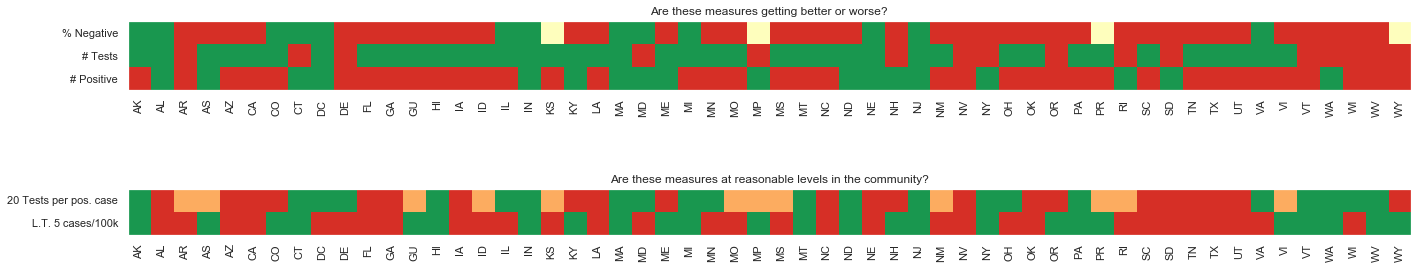

In [109]:
fig, axs = plt.subplots(2, 1, figsize=(20,5))


#rates summary
im = axs[0].imshow(rate_mappings, cmap='RdYlGn', vmin=-1.25, vmax=1.25)
axs[0].set_title('Are these measures getting better or worse?')
# We want to show all ticks...
axs[0].set_xticks(np.arange(len(corona_to_plot.index)))
axs[0].set_yticks(np.arange(3))
# ... and label them with the respective list entries
axs[0].set_xticklabels(corona_to_plot.index.values)
axs[0].set_yticklabels(titles)
axs[0].set_ylim(-0.5,2.5)
axs[0].grid(False)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=90)

#level summary
im = axs[1].imshow(level_mappings, cmap='RdYlGn', vmin=-1.25, vmax=1.25)
axs[1].set_title('Are these measures at reasonable levels in the community?')
# We want to show all ticks...
axs[1].set_xticks(np.arange(len(corona_to_plot.index)))
axs[1].set_yticks(np.arange(2))
# ... and label them with the respective list entries
axs[1].set_xticklabels(corona_to_plot.index.values)
axs[1].set_yticklabels(['L.T. 5 cases/100k', '20 Tests per pos. case'])
axs[1].set_ylim(-0.5,1.5)
axs[1].grid(False)

plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)

plt.tight_layout()
plt.savefig('images/state_by_state_summary.pdf')
plt.savefig('images/state_by_state_summary.svg')

In [110]:
rate_changes = []
rate_changes.append(corona_to_plot['positiveIncrease'+'Rolling'].map(neg_mapping))
rate_changes.append(corona_to_plot['totalTestResultsIncrease'+'IsIncreasing'].map(pos_mapping))
rate_changes.append(corona_to_plot.apply(lambda row: isIncreasingZeroCheck(row['percentNegative'], row['percentNegative'+'IsIncreasing']), axis=1)
)


level_changes = []
level_changes.append((1e5*corona_to_plot['positiveIncreaseRolling']/corona_to_plot['population']).apply(lambda x: 1 if x < 10.0 else -1))
level_changes.append(corona_to_plot['percentNegativeRolling'].apply(lambda x: 0 if x < 1 else (1 if x > 90 else -1)))


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


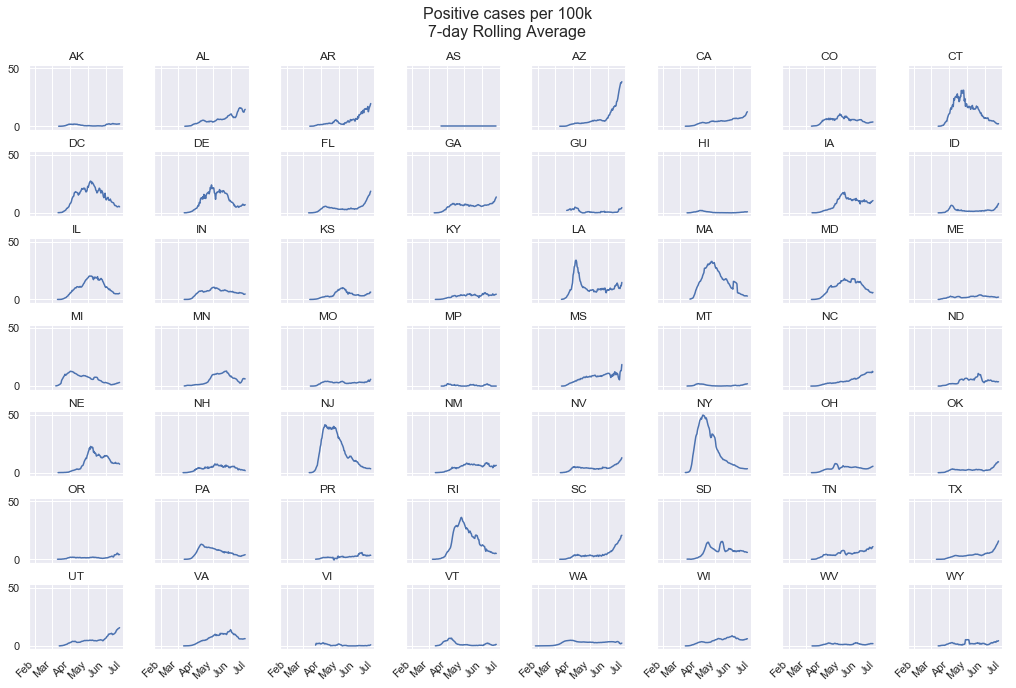

In [112]:
g = sns.relplot(x="date", y="positiveIncreaseRollingPer100k", 
                col='state', 
                data=corona.reset_index(),
               kind="line", 
               col_wrap=8,
               height=1.5, aspect=1.2)
g.fig.autofmt_xdate()
g.set_xticklabels(rotation=45)
date_form = DateFormatter("%b")
g.axes[0,].xaxis.set_major_formatter(date_form)


g.set_ylabels('')
g.set_xlabels('')
g.set_titles('{col_name}')

g.fig.suptitle('Positive cases per 100k\n7-day Rolling Average', y=1.05, fontsize=16)
g.savefig('images/PositiveCases.svg')
g.savefig('images/PositiveCases.pdf')